# Importing libraries

In [66]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Data preparation

In [67]:
train_dir = '/kaggle/input/cats-and-dogs-image-classification/train'
test_dir = '/kaggle/input/cats-and-dogs-image-classification/test'
input_shape = (224, 224, 3)
batch_size = 32

# Data Augmentation & Data Generators

In [68]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generator

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 557 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


# Model Architecture

In [69]:
base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = True  

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


# Callbacks

In [70]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Train Model

In [71]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6235 - loss: 0.7312 - val_accuracy: 0.7429 - val_loss: 0.4679
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - accuracy: 0.9012 - loss: 0.2655 - val_accuracy: 0.8071 - val_loss: 0.3568
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - accuracy: 0.9350 - loss: 0.1701 - val_accuracy: 0.9214 - val_loss: 0.2737
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 497ms/step - accuracy: 0.9380 - loss: 0.1358 - val_accuracy: 0.9714 - val_loss: 0.2269
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 501ms/step - accuracy: 0.9694 - loss: 0.0932 - val_accuracy: 0.9643 - val_loss: 0.2043
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - accuracy: 0.9792 - loss: 0.0667 - val_accuracy: 0.9714 - val_loss: 0.1719
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - accuracy: 0.9792 - loss: 0.0437 - val_accuracy: 0.9786 - val_loss: 0.1519
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 516ms/step - accuracy: 0.9905 - loss: 0.0346 - val_accurac

# Evaluation Phase

In [72]:
test_generator.reset()
preds = model.predict(test_generator)
pred_labels = (preds >= 0.5).astype(int).reshape(-1)
true_labels = test_generator.classes

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Cat', 'Dog']))


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 620ms/step

Classification Report:
              precision    recall  f1-score   support

         Cat       0.93      0.99      0.96        70
         Dog       0.98      0.93      0.96        70

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140



# Confusion_matrix

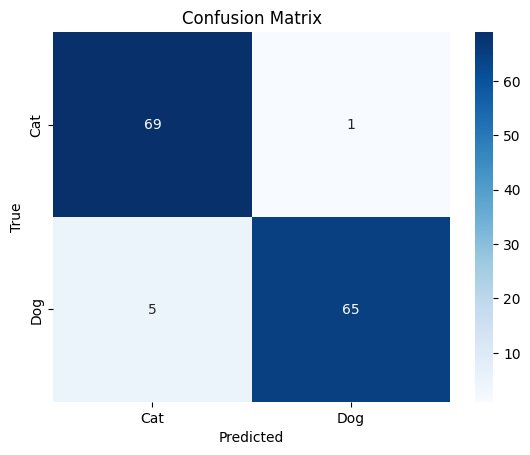

In [73]:
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Prediction

In [74]:
def predict_single_image(model, img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = 'Dog' if prediction >= 0.5 else 'Cat'
    confidence = prediction if prediction >= 0.5 else 1 - prediction
    
    plt.imshow(load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediction: {label}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


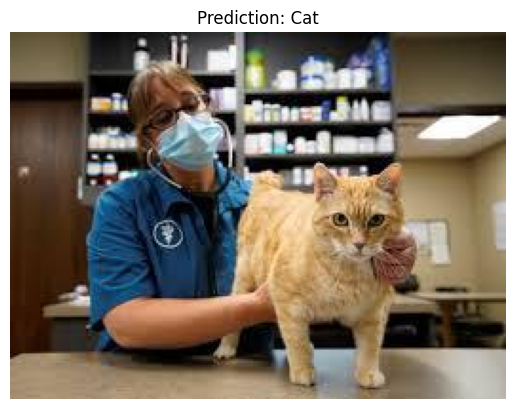

In [75]:
example_path = '/kaggle/input/cats-and-dogs-image-classification/test/cats/cat_244.jpg'
predict_single_image(model, example_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


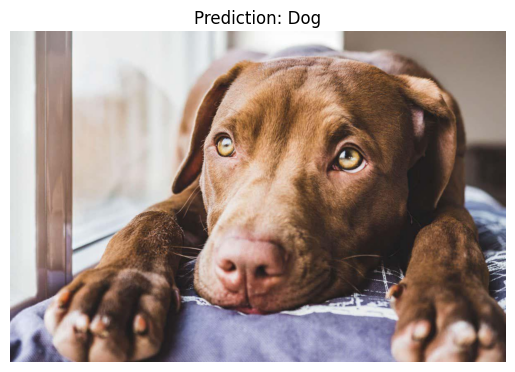

In [76]:
example_path = '/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_191.jpg'
predict_single_image(model, example_path)